<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/STORM_Toy_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import random #not used
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Step 0: Make a toy land mask
# ---------------------------
def make_land_mask(lat_range=(5, 25), lon_range=(-80, -40), res=1.0):
    lats = np.arange(lat_range[0], lat_range[1] + res, res)
    lons = np.arange(lon_range[0], lon_range[1] + res, res)
    mask = np.zeros((len(lats), len(lons)))  # 0 = ocean

    # Toy rule: land for lon > -60 (e.g., Africa-like coast)
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            if lon > -60: #can change coast line to be more complex but for now just a vertical line
                mask[i, j] = 1  # land
    return lats, lons, mask
    #this just gives us an array of 0 and 1 with 1 being land it is used later to see if the storm is on land or not

# ---------------------------
# Step 1: Annual storm counts
# ---------------------------
def sample_storms_per_year(mean_storms=12):
    return np.random.poisson(mean_storms)
#stochastic frequency sampling we are using numpy's random poisson distribution with a mean of 12 (or user inputed) to get the number of storms in a year
# ---------------------------
# Step 2: Genesis location with land check
# ---------------------------
def sample_genesis_locations(n_storms, basin_bounds, lats, lons, mask): #last three are from make_land_mask?
    lat0, lat1, lon0, lon1 = basin_bounds
    #basin_bounds is a user input (unpack the bounds provided)
    chosen = []
    #initialize list to hold genesis points
    while len(chosen) < n_storms: #n_storm comes from the sample_storms_per_year as dictated in the run _STORM function
        lat = np.random.uniform(lat0, lat1) #random inside basin
        lon = np.random.uniform(lon0, lon1)
        # Convert to mask indices
        i = int((lat - lat0) / (lat1 - lat0) * (len(lats) - 1)) #make sure it is an integer? and in same shape as the mask made before? (rows)
        j = int((lon - lon0) / (lon1 - lon0) * (len(lons) - 1)) #columns
        if mask[i, j] == 0:  # must be ocean #uses make_land_mask function array output
            chosen.append((lat, lon))
    return chosen #chose is a list of lat, lon point the length of n_storms
    #might be worth adding a max attempts limit to prevent issues if no ocean as impossible to pass this test

# ---------------------------
# Step 3: Track simulation
# ---------------------------
def simulate_track(lat, lon, n_steps=20):
    lats = [lat] # pull our gensis points
    lons = [lon]
    for _ in range(n_steps): #predefined 20 steps to keep small
        dlat = np.random.normal(0.1, 0.2) #create north east drift as these are storms off the coast of africa
        dlon = np.random.normal(0.3, 0.4) # this is the random walk small northward step
        lats.append(lats[-1] + dlat) #append the new lat to the list small eastward step
        lons.append(lons[-1] + dlon)
    return lats, lons #Step units are degrees per step (toy). In a real model you’d use time steps and convert speed/direction to lat/lon displacements (and handle longitude wrap-around).

# ---------------------------
# Step 4: Intensity evolution
# ---------------------------
def simulate_intensity(n_steps=20): #make sure n_steps is same as above
    p0 = np.random.uniform(1000, 1010) #initial central pressure (hPa) near genesis (random).
    p_min = np.random.uniform(880, 970) #minimum (strongest) pressure the storm reaches.
    half = n_steps // 2 #integer half of steps: first half is intensification, second half decay.
    fall = np.linspace(p0, p_min, half) # pressures from genesis to minimum
    rise = np.linspace(p_min, 1015, n_steps - half) #decay back up to a weak state (1015 hPa).
    pressure = np.concatenate([fall, rise]) #full pressure time series. combine the other arrays
    wind = 1500 / pressure #toy formula converting pressure to wind (not physically rigorous, just illustrative).
    return pressure, wind

# ---------------------------
# Step 5: Check landfall
# ---------------------------
def check_landfall(track_lat, track_lon, lats, lons, mask, basin_bounds):
    lat0, lat1, lon0, lon1 = basin_bounds
    flags = []
    for lat, lon in zip(track_lat, track_lon):
        # Convert to indices
        i = int((lat - lat0) / (lat1 - lat0) * (len(lats) - 1))
        j = int((lon - lon0) / (lon1 - lon0) * (len(lons) - 1))
        if 0 <= i < len(lats) and 0 <= j < len(lons):
            flags.append(mask[i, j])
        else:
            flags.append(0)
    return flags

# ---------------------------
# Step 6: Run Simulation
# ---------------------------
def run_STORM(years=2, basin_bounds=(5, 25, -80, -40)):
    lats, lons, mask = make_land_mask((5, 25), (-80, -40))
    records = []  # instead of numpy array

    for year in range(years):
        n_storms = sample_storms_per_year()
        genesis_points = sample_genesis_locations(n_storms, basin_bounds, lats, lons, mask)

        for sid, (lat, lon) in enumerate(genesis_points):
            track_lat, track_lon = simulate_track(lat, lon)
            pressure, wind = simulate_intensity(len(track_lat))
            landfall_flags = check_landfall(track_lat, track_lon, lats, lons, mask, basin_bounds)

            for t in range(len(track_lat)):
                records.append({
                    "year": year,
                    "storm_id": sid,
                    "time_step": t,
                    "lat": track_lat[t],
                    "lon": track_lon[t],
                    "pressure": pressure[t],
                    "wind": wind[t],
                    "landfall": landfall_flags[t]
                })

    # Convert to DataFrame
    return pd.DataFrame(records)


In [56]:
def plot_tracks(df, basin_bounds=(5, 25, -80, -40)):
    # --- Land mask for coastline ---
    lats, lons, mask = make_land_mask((basin_bounds[0], basin_bounds[1]),
                                      (basin_bounds[2], basin_bounds[3]))

    plt.figure(figsize=(8, 6))

    # Plot land mask (grey shading for land cells)
    plt.contourf(lons, lats, mask, levels=[0.5, 1.5], colors=["lightgrey"])

    # --- Normalize wind speeds for scaling marker sizes ---
    wind_min, wind_max = df["wind"].min(), df["wind"].max()
    size_min, size_max = 20, 200  # circle size range
    df = df.copy()  # avoid modifying original
    df["wind_size"] = size_min + (df["wind"] - wind_min) / (wind_max - wind_min + 1e-6) * (size_max - size_min)

    # Plot storm tracks
    for (year, storm_id), group in df.groupby(["year", "storm_id"]):
        label = f"Storm {year}-{int(storm_id)}"
        plt.plot(group["lon"], group["lat"], lw=1, label=label)

        # Plot points along the track, size ∝ normalized wind
        plt.scatter(
            group["lon"], group["lat"],
            s=group["wind_size"],
            c="blue", alpha=0.4, edgecolors="k", linewidth=0.3
        )

        # Highlight landfalls
        landfalls = group[group["landfall"] == 1]
        if not landfalls.empty:
            plt.scatter(
                landfalls["lon"], landfalls["lat"],
                c="red", marker="x", s=40, label="Landfall"
            )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Synthetic Storm Tracks with Coastline")
    plt.xlim(basin_bounds[2], basin_bounds[3])
    plt.ylim(basin_bounds[0], basin_bounds[1])

    # Deduplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=7)

    plt.grid(True)
    plt.show()


   year  storm_id  time_step        lat        lon     pressure      wind  \
0     0         0          0  15.963975 -76.760351  1001.238146  1.498145   
1     0         0          1  16.303914 -76.795603   990.726400  1.514041   
2     0         0          2  16.363503 -76.449241   980.214654  1.530277   
3     0         0          3  16.288091 -75.738730   969.702908  1.546866   
4     0         0          4  16.447229 -75.342015   959.191162  1.563818   

   landfall  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


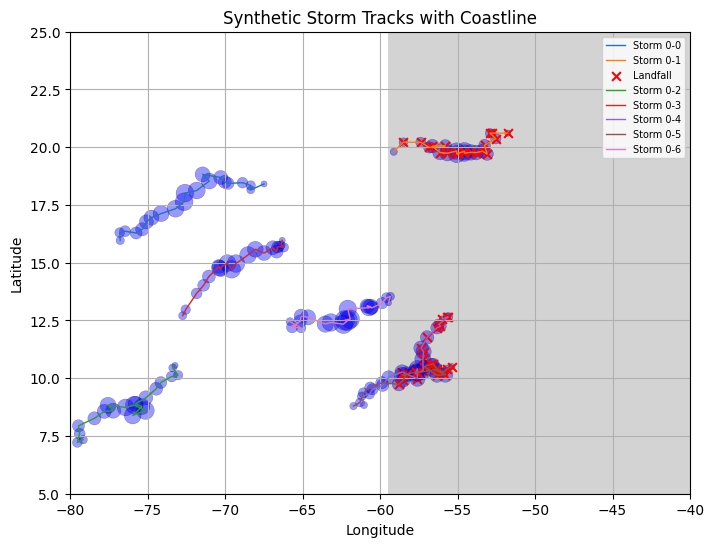

In [57]:
df = run_STORM(years=1)
print(df.head())
plot_tracks(df)